# Metagenomics: Compositional Data Analysis

In [13]:
# Export nb with no code input: 
# jupyter nbconvert *.ipynb --to html --no-input


In [14]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [15]:
## Supress warnings due to Python version shennanigans

# Pandas 'caveats': https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

# Suppress stderror in iPython cell (adapted from): https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython 
from IPython.display import HTML

# Suppress FutureWarning from numpy (adapted from): https://stackoverflow.com/questions/57704412/how-to-suppress-future-warning-tensorflow
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Python and package versions at time of writing:

In [16]:
## Package versions at time of writing
# As of 2022-11-08, everything works

print("Python version:")
print(sys.version)

# Script source for listing imported packages: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

Python version:
3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]
matplotlib==3.6.2
numpy==1.23.3
pandas==1.4.4


## Resfinder
***

**`resfinder` dataframe pre-prepared by running the python script (`mapstat_abundance.py`) on the mapstat files.**

**Resfinder AMR fragments isolated for each sample:**

In [17]:
# Reading in resfinder and 'pivotting' or 'transposing' dimensions
# Note: The values in 'SampleX' are 'abundace' or 'number of fragments' (from the fragmentCountAln column)
resfinder = pd.read_csv('./resfinder/resfinder_abundance_table_24_25_38.csv')
resfinder_headers = list(resfinder.columns)
resfinder_transposed = resfinder.transpose()
resfinder_transposed['Gene'] = resfinder.columns
resfinder_transposed = resfinder_transposed.reset_index(drop=True)
resfinder_transposed.columns = ['Sample24', 'Sample25', 'Sample38', 'Gene']
# resfinder_transposed

In [18]:
# Isolating each sample into its own dataframe

resfinder_24 = resfinder_transposed[['Sample24','Gene']]
resfinder_25 = resfinder_transposed[['Sample25','Gene']]
resfinder_38 = resfinder_transposed[['Sample38','Gene']]

resfinder_24.rename(columns={"Sample24":"Abundance"}, inplace=True)
resfinder_25.rename(columns={"Sample25":"Abundance"}, inplace=True)
resfinder_38.rename(columns={"Sample38":"Abundance"}, inplace=True)

print("Resfinder sample 24")
display(resfinder_24)
print("Resfinder sample 25")
display(resfinder_25)
print("Resfinder sample 38")
display(resfinder_38)

Resfinder sample 24


,Abundance,Gene
0,117.0,Cfr(E)_1_NG_070225
1,30.0,VanG2XY_1_FJ872410
2,6.0,VanGXY_1_AY271782
3,0.0,VanHBX_1_AF192329
4,0.0,aac(6')-Im_1_AF337947
...,...,...
104,0.0,tet(X5)_1_CP040912
105,33.0,tetA(P)_1_AB054980
106,86.0,tetA(P)_2_L20800
107,92.0,tetB(P)_1_NC_010937


Resfinder sample 25


,Abundance,Gene
0,532.0,Cfr(E)_1_NG_070225
1,66.0,VanG2XY_1_FJ872410
2,33.0,VanGXY_1_AY271782
3,24.0,VanHBX_1_AF192329
4,0.0,aac(6')-Im_1_AF337947
...,...,...
104,26.0,tet(X5)_1_CP040912
105,46.0,tetA(P)_1_AB054980
106,207.0,tetA(P)_2_L20800
107,34.0,tetB(P)_1_NC_010937


Resfinder sample 38


,Abundance,Gene
0,78.0,Cfr(E)_1_NG_070225
1,19.0,VanG2XY_1_FJ872410
2,0.0,VanGXY_1_AY271782
3,0.0,VanHBX_1_AF192329
4,3.0,aac(6')-Im_1_AF337947
...,...,...
104,0.0,tet(X5)_1_CP040912
105,5.0,tetA(P)_1_AB054980
106,30.0,tetA(P)_2_L20800
107,7.0,tetB(P)_1_NC_010937


**Dataframe info:**

In [19]:
# Dataframe info
resfinder.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 109 entries, Cfr(E)_1_NG_070225 to vat(E)_5_AJ488494
dtypes: float64(109)

**There are >100 headers, so we want to 'amalgamate' AMR gene classes eventually.**

**Using the `ResFinder_classes.tsv`, we can find our how many unique class groups there are.**

In [20]:
# Loading Resfinder classes dataset as dataframe
resfinder_classes = pd.read_csv('./resfinder/ResFinder_classes.tsv', sep='\t', header=None, names=['Gene','Class'])
# Creating dict, for renaming columns
dict_resfinder_classes = resfinder_classes.set_index('Gene')['Class'].to_dict() 
# Sorting genes into classes 
resfinder_classes_renamed = resfinder.rename(columns=dict_resfinder_classes)
# Unique classes
resfinder_classes_renamed.columns.unique()

Index(['Phenicol', 'Glycopeptide', 'Aminoglycoside', 'Beta-Lactam',
       'Macrolide', 'Nitroimidazole', 'Sulphonamide', 'Tetracycline',
       'tet(O/32/O)_6_NG_048124'],
      dtype='object')

**There are 8 unique classes (a 9th one that seems to fit into Tetracycline - we could merge it, or discard it).**

**We need the fragment length data (found in dataframe: `ResFinder.length`) and their corresponding gene names (`ResFinder.name`) for CoDa later on.** 

**After merging `resfinder_{24,25,38}` with the fragment length + gene names dataframes, and performing an amalgamation (by simply summing values belonging to the same gene class), we get the following dataframes:**

In [21]:
# Merging all resfinder dataframes
resfinder_24["Class"]=resfinder_24["Gene"].map(dict_resfinder_classes)
resfinder_25["Class"]=resfinder_25["Gene"].map(dict_resfinder_classes)
resfinder_38["Class"]=resfinder_38["Gene"].map(dict_resfinder_classes)

# Read in resfinder length database
resfinder_name = pd.read_csv('./resfinder/ResFinder.name', sep='\t', header=None, names=['Gene'])
resfinder_length = pd.read_csv('./resfinder/ResFinder.length', sep='\t', header=None, names=['Length'])


# Create dict for inserting lengths
dict_resfinder_length = pd.DataFrame()
dict_resfinder_length['Gene']=resfinder_name['Gene']
dict_resfinder_length['Length']=resfinder_length['Length']
dict_resfinder_length = dict_resfinder_length.set_index('Gene')['Length'].to_dict()

resfinder_24["Length"]=resfinder_24["Gene"].map(dict_resfinder_length)
resfinder_25["Length"]=resfinder_25["Gene"].map(dict_resfinder_length)
resfinder_38["Length"]=resfinder_38["Gene"].map(dict_resfinder_length)

print("Sample 24 with AMR class and fragment Length data")
display(resfinder_24)
print("Sample 25 with AMR class and fragment Length data")
display(resfinder_25)
print("Sample 38 with AMR class and fragment Length data")
display(resfinder_38)

# Suppress warnings
#HTML('''<script> code_show_err=false; </script>''')


Sample 24 with AMR class and fragment Length data


,Abundance,Gene,Class,Length
0,117.0,Cfr(E)_1_NG_070225,Phenicol,1035
1,30.0,VanG2XY_1_FJ872410,Glycopeptide,1811
2,6.0,VanGXY_1_AY271782,Glycopeptide,1811
3,0.0,VanHBX_1_AF192329,Glycopeptide,2607
4,0.0,aac(6')-Im_1_AF337947,Aminoglycoside,537
...,...,...,...,...
104,0.0,tet(X5)_1_CP040912,Tetracycline,1167
105,33.0,tetA(P)_1_AB054980,Tetracycline,1263
106,86.0,tetA(P)_2_L20800,Tetracycline,1263
107,92.0,tetB(P)_1_NC_010937,Tetracycline,1959


Sample 25 with AMR class and fragment Length data


,Abundance,Gene,Class,Length
0,532.0,Cfr(E)_1_NG_070225,Phenicol,1035
1,66.0,VanG2XY_1_FJ872410,Glycopeptide,1811
2,33.0,VanGXY_1_AY271782,Glycopeptide,1811
3,24.0,VanHBX_1_AF192329,Glycopeptide,2607
4,0.0,aac(6')-Im_1_AF337947,Aminoglycoside,537
...,...,...,...,...
104,26.0,tet(X5)_1_CP040912,Tetracycline,1167
105,46.0,tetA(P)_1_AB054980,Tetracycline,1263
106,207.0,tetA(P)_2_L20800,Tetracycline,1263
107,34.0,tetB(P)_1_NC_010937,Tetracycline,1959


Sample 38 with AMR class and fragment Length data


,Abundance,Gene,Class,Length
0,78.0,Cfr(E)_1_NG_070225,Phenicol,1035
1,19.0,VanG2XY_1_FJ872410,Glycopeptide,1811
2,0.0,VanGXY_1_AY271782,Glycopeptide,1811
3,0.0,VanHBX_1_AF192329,Glycopeptide,2607
4,3.0,aac(6')-Im_1_AF337947,Aminoglycoside,537
...,...,...,...,...
104,0.0,tet(X5)_1_CP040912,Tetracycline,1167
105,5.0,tetA(P)_1_AB054980,Tetracycline,1263
106,30.0,tetA(P)_2_L20800,Tetracycline,1263
107,7.0,tetB(P)_1_NC_010937,Tetracycline,1959


## Silva
***

**KMA output from silva db is used to determine the bacterial content of the samples.** 

**To do this, we simply find the proportion of samples that are bacterial, and find the proportion of reads out of the total reads.**

**This data can be obtained directly from silva `*.mapstat` files.**

**Crunching the numbers results in following bacterial proportions:**


In [22]:
# Find True bacterial content, by computing bacterial readCount / total readCount

# SAMPLE 24
silva_24 = pd.read_csv('./silva/silva_24.mapstat', skiprows=6, sep='\t')[["# refSequence","fragmentCount"]]
silva_24.columns = ["TaxID","fragmentCount"]

silva_24_bacteria_index = silva_24["TaxID"]
silva_24_bacteria_index = silva_24["TaxID"].str.contains('Bacteria')

silva_24_fragmentcount = silva_24["fragmentCount"]

silva_24_bacteria_content = silva_24_fragmentcount[silva_24_bacteria_index].sum()
silva_24_total_content = silva_24_fragmentcount.sum()

# SAMPLE 25
silva_25 = pd.read_csv('./silva/silva_25.mapstat', skiprows=6, sep='\t')[["# refSequence","fragmentCount"]]
silva_25.columns = ["TaxID","fragmentCount"]

silva_25_bacteria_index = silva_25["TaxID"]
silva_25_bacteria_index = silva_25["TaxID"].str.contains('Bacteria')

silva_25_fragmentcount = silva_25["fragmentCount"]

silva_25_bacteria_content = silva_25_fragmentcount[silva_25_bacteria_index].sum()
silva_25_total_content = silva_25_fragmentcount.sum()

# SAMPLE 38
silva_38 = pd.read_csv('./silva/kma_silva_38.mapstat', skiprows=6, sep='\t')[["# refSequence","readCount"]]
silva_38.columns = ["TaxID","fragmentCount"]

silva_38_bacteria_index = silva_38["TaxID"]
silva_38_bacteria_index = silva_38["TaxID"].str.contains('Bacteria')

silva_38_fragmentcount = silva_38["fragmentCount"]

silva_38_bacteria_content = silva_38_fragmentcount[silva_38_bacteria_index].sum()
silva_38_total_content = silva_38_fragmentcount.sum()

sample_24_bacterial_content = silva_24_bacteria_content/silva_24_total_content
sample_25_bacterial_content = silva_25_bacteria_content/silva_25_total_content
sample_38_bacterial_content = silva_38_bacteria_content/silva_38_total_content

print("Sample 24 bacterial content:")
print(round(sample_24_bacterial_content,3))
print("Sample 25 bacterial content:")
print(round(sample_25_bacterial_content,2))
print("Sample 38 bacterial content:")
print(round(sample_38_bacterial_content,3))


Sample 24 bacterial content:
0.99
Sample 25 bacterial content:
0.98
Sample 38 bacterial content:
0.96


**This demonstrates that the amount of non-bacterial reads in our sample is effectively negligible.**

**However, they are scalar quantities, using them in FPKM calculations is easy, so we will still use them.**

**In addition, we we need the total number of total fragment for each sample.** 

**This can also be found in the `*.mapstat` files, and is found by summing up the `fragmentCount` columns:**

In [23]:
# Basically just sum up the bpTotal column
silva_24_fragment_count = pd.read_csv('./silva/silva_24.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_24_fragment_count = silva_24_fragment_count[0]
print("Sample 24 total fragment")
print(silva_24_fragment_count)

silva_25_fragment_count = pd.read_csv('./silva/silva_25.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_25_fragment_count = silva_25_fragment_count[0]
print("Sample 25 total fragment")
print(silva_25_fragment_count)

silva_38_fragment_count = pd.read_csv('./silva/kma_silva_38.mapstat',skiprows=6,sep='\t',usecols=['fragmentCount']).sum()
silva_38_fragment_count = silva_38_fragment_count[0]
print("Sample 38 total fragment")
print(silva_38_fragment_count)

Sample 24 total fragment
102963
Sample 25 total fragment
299937
Sample 38 total fragment
59954


# CoDa
***

**For the actual CoDa section, we will compute:** 

- ALR (a.k.a. log(FPKM) values - which tell us about composition of a SPECIFIC composition.

- CLR values - which tells us about the differences in compositions BETWEEEN samples.


**Key differences:**

ALR values between samples CANNOT be compared, whereas CLR values between samples CAN be compared.

The ALR values are closed to total READS, whereas CLR values are closed to total AMR FRAGMENTS

## ALR a.k.a. log(FPKM) 

In order to perform CoDa via FPKM values, we need both the data from the Silva and Resfinder databases.

The Resfinder database provides us information on the resistance genes - which ones, how many fragments we get, and how long the fragments are.

The Silva database provides us with information on how many of our genes are actually bacterial 

FPKM is fragments per kilo basepairs, per million.

The number of fragments of a specific AMR, the kilo basepairs is the bp length of the specific AMR gene (times 10^-3, or 10^3 in the numerator term).

The Millions of basepairs, is the length of your sample, which is found by summing the fragmentTotal column in Silva `*.mapstat` files 

We will use the values of `resfinder_{24,25,38}` (Dataframe containing Gene, Class, Abundance and Length), `sample_{24,25,38}_bacterial_content` (proportion bacterial reads),and `silva_{24,25,38}_fragment_count` (number total fragments)

**Note:** *there is a hidden step, where be remove rows containing zeros - reason being they break down in the context of a log transformation. We do this by replacing the zeros with a very small number. In this case, 1 - denoting a single gene fragment.* 

In [24]:
# Replace zero's with 1's (important for CoDa section)

resfinder_24['Abundance'][resfinder_24.Abundance == 0] = 1
resfinder_25['Abundance'][resfinder_25.Abundance == 0] = 1
resfinder_38['Abundance'][resfinder_38.Abundance == 0] = 1

In [25]:
# Compute FKPM values
resfinder_24['FPKM']=(resfinder_24['Abundance']*1000*1000000)/(sample_24_bacterial_content*resfinder_24['Length']*silva_24_fragment_count)
resfinder_25['FPKM']=(resfinder_25['Abundance']*1000*1000000)/(sample_25_bacterial_content*resfinder_25['Length']*silva_25_fragment_count)
resfinder_38['FPKM']=(resfinder_38['Abundance']*1000*1000000)/(sample_38_bacterial_content*resfinder_38['Length']*silva_38_fragment_count)

In [26]:
# Perform amalgamation
grouped_24 = resfinder_24.groupby('Class').sum()
grouped_25 = resfinder_25.groupby('Class').sum()
grouped_38 = resfinder_38.groupby('Class').sum()

# print("Amalgamated abundance, length and FPKM values for sample 24")
# display(grouped_24)

### **log(FKPM) values**

In [27]:
# Compute log(FKPM) values
grouped_24["logFPKM"] = np.log(grouped_24["FPKM"])
grouped_25["logFPKM"] = np.log(grouped_25["FPKM"])
grouped_38["logFPKM"] = np.log(grouped_38["FPKM"])

grouped_24["Class"]= list(grouped_24.index)
grouped_24 = grouped_24.reset_index(drop=True)

grouped_25["Class"]= list(grouped_25.index)
grouped_25 = grouped_25.reset_index(drop=True)

grouped_38["Class"]= list(grouped_38.index)
grouped_38 = grouped_38.reset_index(drop=True)

print("log(FPKM) values for sample 24")
display(grouped_24)

print("log(FPKM) values for sample 25")
display(grouped_25)

print("log(FPKM) values for sample 38")
display(grouped_38)

grouped_24.to_csv('~/Desktop/ALR_24.csv')
grouped_25.to_csv('~/Desktop/ALR_25.csv')
grouped_38.to_csv('~/Desktop/ALR_38.csv')


log(FPKM) values for sample 24


,Abundance,Length,FPKM,logFPKM,Class
0,2075.0,11646,23646.402571,10.070966,Aminoglycoside
1,2355.0,10494,23631.693263,10.070344,Beta-Lactam
2,37.0,6229,198.710407,5.291849,Glycopeptide
3,10794.0,24414,109370.620913,11.602498,Macrolide
4,2.0,993,39.504885,3.676424,Nitroimidazole
5,164.0,3426,1491.568328,7.307583,Phenicol
6,2.0,1668,23.528942,3.158231,Sulphonamide
7,38345.0,77444,199703.202365,12.204588,Tetracycline


log(FPKM) values for sample 25


,Abundance,Length,FPKM,logFPKM,Class
0,5981.0,11646,23616.859185,10.069716,Aminoglycoside
1,4991.0,10494,17385.702865,9.763403,Beta-Lactam
2,123.0,6229,217.147267,5.380576,Glycopeptide
3,36482.0,24414,126141.482001,11.745159,Macrolide
4,34.0,993,232.730700,5.449882,Nitroimidazole
5,816.0,3426,2534.642673,7.837808,Phenicol
6,38.0,1668,154.447831,5.039856,Sulphonamide
7,86507.0,77444,156621.238674,11.961586,Tetracycline


log(FPKM) values for sample 38


,Abundance,Length,FPKM,logFPKM,Class
0,807.0,11646,16292.280875,9.698447,Aminoglycoside
1,1234.0,10494,21895.573049,9.994040,Beta-Lactam
2,21.0,6229,198.493554,5.290757,Glycopeptide
3,7277.0,24414,120763.458516,11.701589,Macrolide
4,2.0,993,69.971486,4.248088,Nitroimidazole
5,114.0,3426,1810.278935,7.501236,Phenicol
6,2.0,1668,41.674719,3.729895,Sulphonamide
7,13238.0,77444,121829.674592,11.710379,Tetracycline


### **Barplot of log(FPKM) values for all 3 samples**

In [28]:
## Pure matplotlib

# Plot log(FKPM) values against AMR gene classes
# composite_plot, axs = plt.subplots(3, 1, figsize=(11, 8), sharey=True)
# axs[0].bar(grouped_24["Class"], grouped_24["logFPKM"])
# axs[1].bar(grouped_25["Class"], grouped_25["logFPKM"])
# axs[2].bar(grouped_38["Class"], grouped_38["logFPKM"])
# composite_plot.suptitle("Log(FPKM) vs. AMR gene classes for samples 24, 25 and 38")

<AxesSubplot: title={'center': 'SAMPLE 38'}, xlabel='Class', ylabel='logFPKM'>

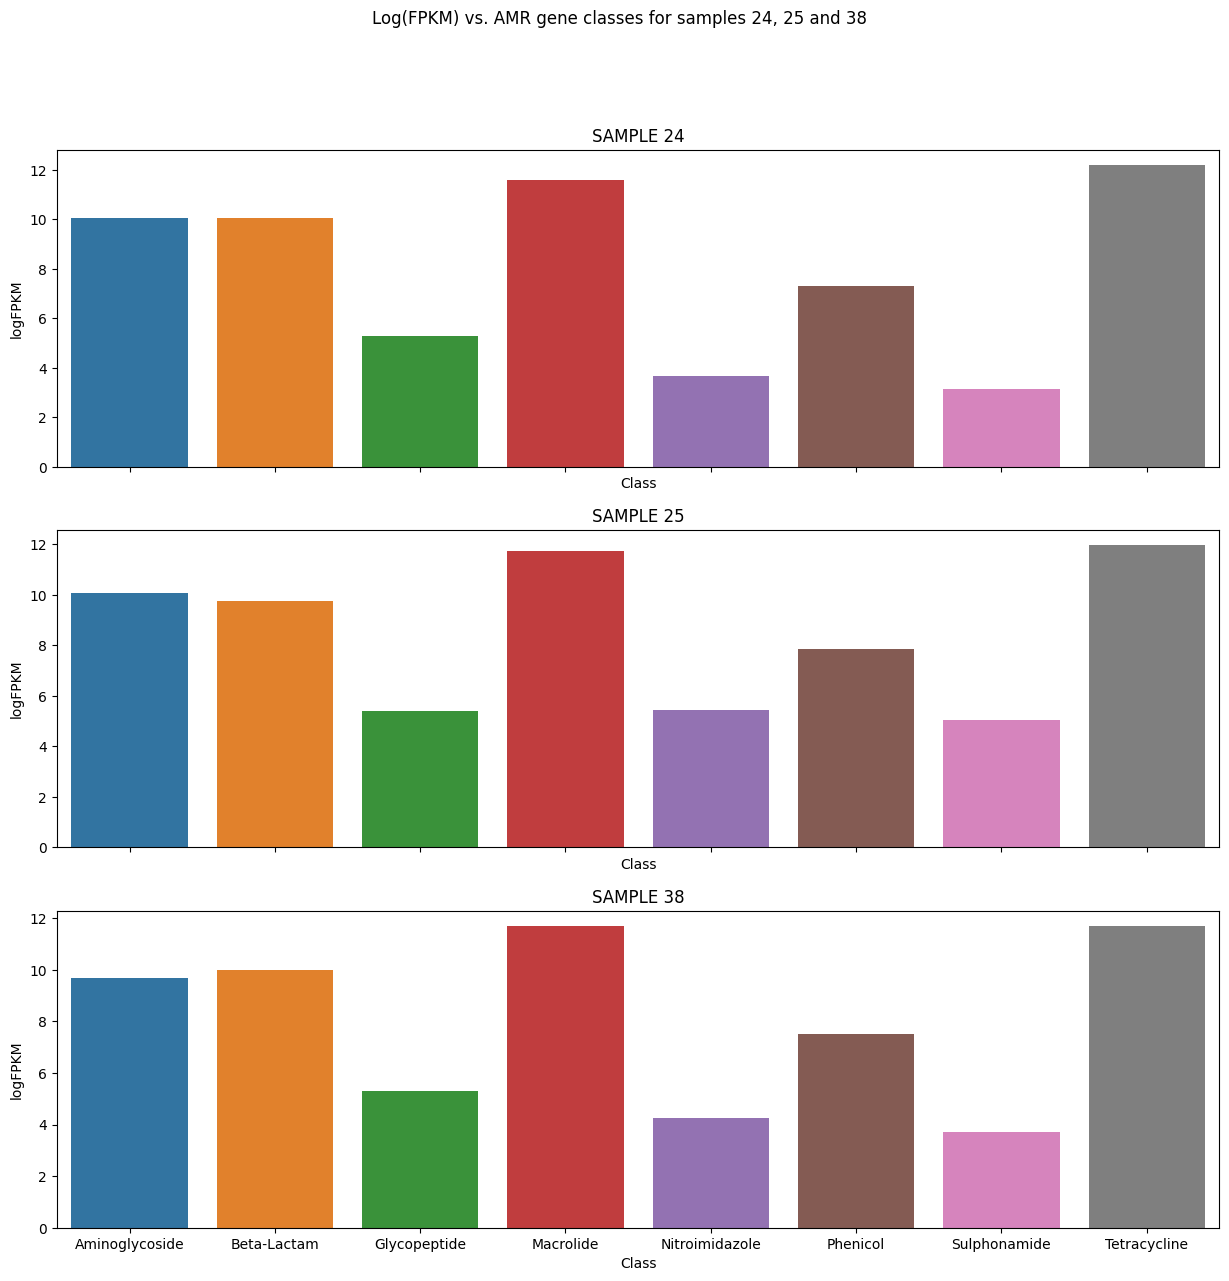

In [29]:
## matplotlib + seaborn
# https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

composite_plot_sns, axes = plt.subplots(3, 1, figsize=(15, 14), sharex=True)
composite_plot_sns.suptitle("Log(FPKM) vs. AMR gene classes for samples 24, 25 and 38")
axes[0].set_title("SAMPLE 24")
sns.barplot(data=grouped_24, ax=axes[0], x=grouped_24["Class"], y=grouped_24["logFPKM"])
axes[1].set_title("SAMPLE 25")
sns.barplot(data=grouped_25, ax=axes[1], x=grouped_25["Class"], y=grouped_25["logFPKM"])
axes[2].set_title("SAMPLE 38")
sns.barplot(data=grouped_38, ax=axes[2],  x=grouped_38["Class"], y=grouped_38["logFPKM"])

## CLR

**CLR values are computed by taking the original `resfinder_{24,25,38}` values, and performing 'Closure' to them (basically normalization).** 

**Since we have used number of AMR fragments, we will use the total fragments (found in `fragmentCountAln` colunn of `resfinder` `*.mapstat` files).**

**Having performed closure, we amalgamate after AMR gene classes, as we did before with ARL. We now perform CLR. This can be done by dividing our fragment abundances by the geometric mean for each column, and log transforming.**

In [30]:
# Find total fragment to perform closure

total_fragment_24 = pd.read_csv('./resfinder/resfinder_ERR2597524.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()
total_fragment_25 = pd.read_csv('./resfinder/resfinder_ERR2597524.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()
total_fragment_38 = pd.read_csv('./resfinder/kma_resfinder_38.mapstat', skiprows=6, sep='\t')[["fragmentCountAln"]].sum()

### CLR values

In [31]:
resfinder_clr = pd.DataFrame()
resfinder_clr["CLR(24)"] = resfinder_24["Abundance"]
resfinder_clr["CLR(25)"] = resfinder_25["Abundance"]
resfinder_clr["CLR(38)"] = resfinder_38["Abundance"]
resfinder_clr["Class"] = resfinder_24["Class"]

# resfinder_clr

**Resulting CLR values after applying closure and amalgamating after AMR gene classes:**

In [32]:
# Compute CLR values for all samples

resfinder_clr = pd.DataFrame()

resfinder_clr["CLR(24)"] = resfinder_24["Abundance"]/total_fragment_24[0]
resfinder_clr["CLR(25)"] = resfinder_25["Abundance"]/total_fragment_25[0]
resfinder_clr["CLR(38)"] = resfinder_38["Abundance"]/total_fragment_38[0]
resfinder_clr["Class"] = resfinder_24["Class"]

resfinder_clr = resfinder_clr.groupby("Class").sum().transpose()

def gmean(row):
    """Calculate gmean."""
    return np.exp(
        (1 / len(row)) * np.log(row).sum()
    )

# calculate CLR
resfinder_clr = resfinder_clr.apply(lambda x: np.log(x / gmean(x)), axis=1).transpose()

resfinder_clr.reset_index(inplace=True)

display(resfinder_clr)

print("Sum of CLR values (they should sum to ~zero):")
print("sum(CLR(24)):")
print(resfinder_clr["CLR(24)"].sum())
print("sum(CLR(25)):")
print(resfinder_clr["CLR(25)"].sum())
print("sum(CLR(38)):")
print(resfinder_clr["CLR(38)"].sum())
print("Sums are small enough so that they are basically zero.")

,Class,CLR(24),CLR(25),CLR(38)
0,Aminoglycoside,1.970189,1.475739,1.523114
1,Beta-Lactam,2.096769,1.294787,1.947807
2,Glycopeptide,-2.056609,-2.408420,-2.125687
3,Macrolide,3.619219,3.283970,3.722264
4,Nitroimidazole,-4.974380,-3.694244,-4.477062
5,Phenicol,-0.567661,-0.516190,-0.434011
6,Sulphonamide,-4.974380,-3.583018,-4.477062
7,Tetracycline,4.886852,4.147376,4.320637


Sum of CLR values (they should sum to ~zero):
sum(CLR(24)):
1.7763568394002505e-15
sum(CLR(25)):
1.7763568394002505e-15
sum(CLR(38)):
-8.881784197001252e-16
Sums are small enough so that they are basically zero.


### **Scatter plot of CLR values for all samples**

In [33]:
# Ignore
# resfinder_clr.to_csv("~/Desktop/resfinder_clr.csv")

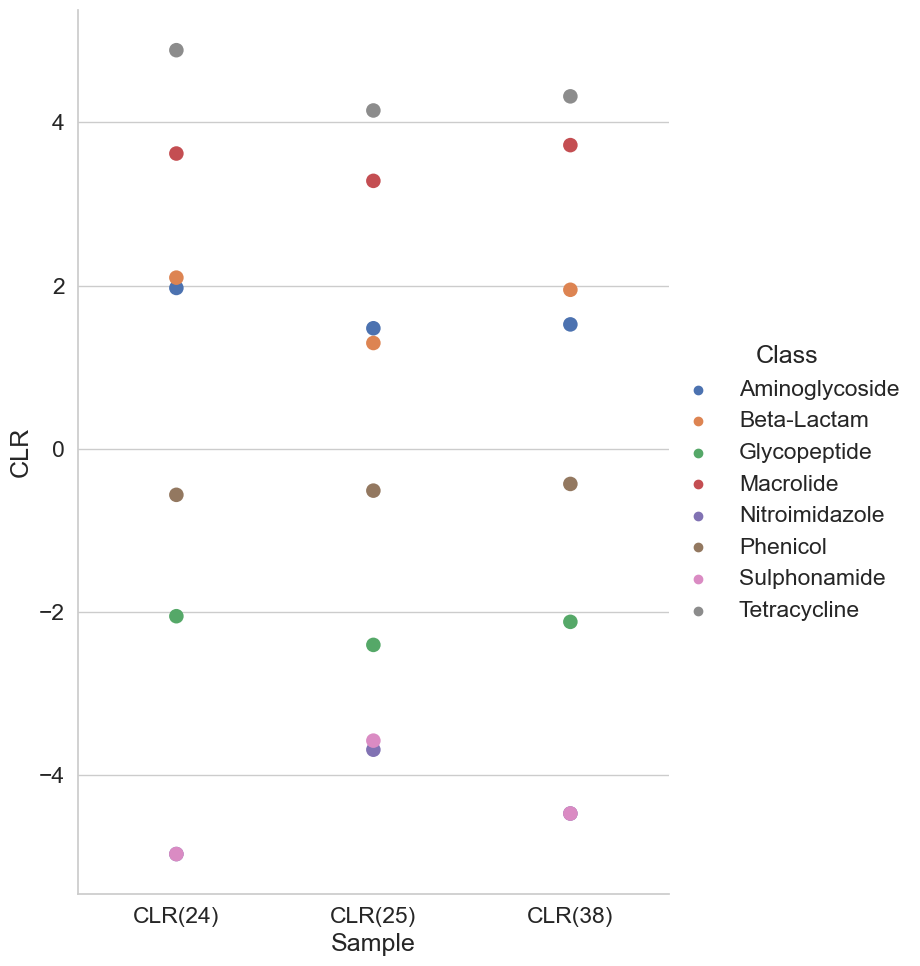

In [34]:
# Plot of CLR values

# To use seaborn's 'hue' function, we need to perform a 'categorisation' by Samples, or 'pivot'. I can't figure out how to use pandas.pivot(), so I'm using dplyr in R

## (Export dataframe to csv)
# resfinder_clr.to_csv("./resfinder/resfinder_clr.csv")

## Perform categorisation in R using exported csv (generates new csv with categorised data)
# resfinder_clr <- read_csv("./resfinder/resfinder_clr.csv")
# resfinder_clr %>% 
#   pivot_longer(cols = c("CLR(24)", "CLR(25)", "CLR(38)"),
#                names_to = "Sample",
#                values_to = "CLR") %>% 
#   write_csv("~/Desktop/resfinder_clr_cat.csv")
# resfinder_clr.to_csv("./resfinder/resfinder_clr.csv")

# Import categorised csv
resfinder_clr_cat = pd.read_csv("./resfinder/resfinder_clr_cat.csv")

# Plot the damn thing
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.catplot(data=resfinder_clr_cat, x="Sample", y="CLR", hue="Class", s=110, jitter=False, height=10, aspect=8/11)

# Follow-up investigation

## Silva genera/species

Gtdb output found Agathobacter, Cryptobacteroides, Prevotella genera and Firmicutes phylum 

In [35]:
print("Agathobacter")
display(silva_24[silva_24["TaxID"].str.contains('Agathobacter')].sum())
print("Prevotella")
display(silva_24[silva_24["TaxID"].str.contains('Prevotella')].sum())
print("Cryptobacteroides - uncultured")
display(silva_24[silva_24["TaxID"].str.contains('Cryptobacteroides')].sum())
print("Firmicutes")
display(silva_24[silva_24["TaxID"].str.contains('Firmicutes')].sum())

Agathobacter


TaxID            FP929043.489815.491335 Bacteria;Firmicutes;Clo...
fragmentCount                                                  859
dtype: object

Prevotella


TaxID            HL282995.10.1520 Bacteria;Bacteroidota;Bactero...
fragmentCount                                                34216
dtype: object

Cryptobacteroides - uncultured


TaxID            0.0
fragmentCount    0.0
dtype: float64

Firmicutes


TaxID            HL282040.1.1532 Bacteria;Firmicutes;Clostridia...
fragmentCount                                                46205
dtype: object

In [36]:
pd.read_csv('./silva/silva_24.mapstat',skiprows=6,sep='\t')

,# refSequence,readCount,fragmentCount,mapScoreSum,refCoveredPositions,refConsensusSum,bpTotal,depthVariance,nucHighDepthVariance,depthMax,snpSum,insertSum,deletionSum,readCountAln,fragmentCountAln
0,HL282040.1.1532 Bacteria;Firmicutes;Clostridia...,1,1,53,56,55,56,0.035217,56,1,1,0,0,1,1
1,HL281884.4.1372 Bacteria;Firmicutes;Clostridia...,1,1,142,151,148,151,0.098134,0,1,3,0,0,1,1
2,HL282039.1.1487 Bacteria;Firmicutes;Clostridia...,1,1,109,133,125,133,0.081442,133,1,8,0,0,1,1
3,HL282260.2.1394 Bacteria;Desulfobacterota;Desu...,1,1,111,141,131,141,0.090975,0,1,10,0,0,1,1
4,HL282507.1.1499 Bacteria;Firmicutes;Clostridia...,2,2,284,151,149,296,0.351935,145,2,4,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11524,FMGJ01000002.297823.299313 Bacteria;Firmicutes...,1,1,131,146,141,146,0.088332,146,1,5,0,0,1,1
11525,FMVL01000023.1.1244 Bacteria;Firmicutes;Clostr...,1,1,50,56,54,56,0.042990,56,1,2,0,0,1,1
11526,FMIW01000005.418310.419846 Bacteria;Firmicutes...,9,5,1199,481,481,1199,2.068751,33,6,0,0,0,9,5
11527,FTLM01000021.103.1630 Bacteria;Desulfobacterot...,35,24,4595,1478,1469,4699,1.716194,0,6,33,1,0,35,24
